To investigate how Olympic athletes have changed over the years, I explored an Olympic Games data set from the Kaggle user rgriffin (https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results) which includes data on the age, gender, height, weight, country of origin, and medals won. I restricted the data set to the summer games since 1980 and looked for interesting observations regaring the athletes over the past 40 years and found some thought provoking  trends in the age and gender of recent Olympic athletes. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#set up the plot size default for better images
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#df = pd.read_csv(csv_url)
Athletes_df = pd.read_csv(r"C:\Users\merwi\Desktop\Udacity DS files\Project I\athlete_events.csv")

#select the columns and parameters I want
Ath_df = Athletes_df[['ID','Sex','Age','NOC','Year','Season','Medal']]

Ath_df = Ath_df[Ath_df['Year'] >= 1980]

Ath_df = Ath_df[Ath_df['Season'] == 'Summer']

Ath_df.shape[0]


122913

Part I. Correlations. A look at correlations within the data showed some initial observations. As seen in the correlelogram, one of the strongest, positive correlations observed was that between the total number of athletes a country sends to the games and the number of medals that country wins. For the purposes for this study, medals were weighted by their rank with gold being worth 3, silver worth 2 adn bronze worth 1. 

In [3]:
# check columns for null values. If there are nulls in the age column that can affect the conclusions drawn from averages. 
col_null = Ath_df.columns[Ath_df.isnull().any()==True].tolist()
# null values in these columns
print(Ath_df[col_null].isnull().sum())

#There are missing values, 551 of them. I will impute the column average for that year whever the data is missing
Ath_df.Age = Ath_df.groupby('Year')['Age'].apply(lambda x: x.fillna(x.mean()))
Ath_df.Age = Ath_df.Age.fillna(Ath_df.Age.mean())
print (Ath_df)


Age         551
Medal    104900
dtype: int64
            ID Sex   Age  NOC  Year  Season Medal
0            1   M  24.0  CHN  1992  Summer   NaN
1            2   M  23.0  CHN  2012  Summer   NaN
31          12   M  31.0  FIN  2000  Summer   NaN
32          13   F  30.0  FIN  1996  Summer   NaN
33          13   F  34.0  FIN  2000  Summer   NaN
...        ...  ..   ...  ...   ...     ...   ...
271105  135565   M  23.0  ARG  2000  Summer   NaN
271106  135565   M  27.0  ARG  2004  Summer   NaN
271108  135567   M  24.0  RUS  2000  Summer   NaN
271109  135567   M  28.0  RUS  2004  Summer   NaN
271110  135568   F  33.0  BLR  2016  Summer   NaN

[122913 rows x 7 columns]


In [4]:
#now lets shape the data a bit and then start with a correlogram
#1. Create a numeric value for medals based on value

# create a list of our conditions
conditions = [
    (Ath_df['Medal'] == 'Gold'),
    (Ath_df['Medal'] == 'Silver'),
    (Ath_df['Medal'] == 'Bronze')
    ]

# create a list of the values we want to assign for each condition
values = [3, 2, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
Ath_df.loc[:,('numeric_medals')] = np.select(conditions, values)

#subset into male and female datasets
Ath_df_m = Ath_df[Ath_df['Sex'] == 'M']
Ath_df_f = Ath_df[Ath_df['Sex'] == 'F']
        
#now add up the medal numbers by country using this formula:  df['Data4'] = df['Data3'].groupby(df['Date']).transform('sum
Sum_m = Ath_df_m.groupby(['NOC','Year']).agg({'numeric_medals':'sum',
                                                 'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

Sum_f = Ath_df_f.groupby(['NOC','Year']).agg({'numeric_medals':'sum',
                                                 'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

merged_df = pd.merge(Sum_m, Sum_f, on=['NOC', 'Year'])
merged_df

#now rename columns
merged_df = merged_df.rename(columns={'numeric_medals_x':'medals_male',
                                      'ID_x':'male_athlete_count',
                                      'Age_x':'male_athlete_age',
                                      'numeric_medals_y':'medals_female',
                                      'ID_y':'female_athlete_count',
                                      'Age_y':'female_athlete_age',
                                     })

#Add Totals for both sexes
merged_df['Total_Athletes'] = merged_df['male_athlete_count']+merged_df['female_athlete_count']
merged_df['Total_Medals'] = merged_df['medals_male']+merged_df['medals_female']
merged_df['Average_Total_Ages'] = ((merged_df['male_athlete_count']*merged_df['male_athlete_age'])+(merged_df['female_athlete_count']*merged_df['female_athlete_age']))/(merged_df['male_athlete_count']+merged_df['female_athlete_count'])

#clean up a bit
merged_df = merged_df.round({'male_athlete_age': 1, 'female_athlete_age': 1, 'Average_Total_Ages': 1})   
merged_df

,NOC,Year,medals_male,male_athlete_count,male_athlete_age,medals_female,female_athlete_count,female_athlete_age,Total_Athletes,Total_Medals,Average_Total_Ages
0,AFG,2004,0,3,19.0,0,2,18.0,5,0,18.6
1,AFG,2008,1,3,22.7,0,1,22.0,4,1,22.5
2,AFG,2012,1,5,25.2,0,1,23.0,6,1,24.8
3,AFG,2016,0,2,27.0,0,1,20.0,3,0,24.7
4,AHO,1984,0,6,17.3,0,7,19.0,13,0,18.2
...,...,...,...,...,...,...,...,...,...,...,...
1537,ZIM,2000,0,18,27.0,0,8,20.4,26,0,25.0
1538,ZIM,2004,0,9,26.0,6,5,23.4,14,6,25.1
1539,ZIM,2008,0,8,26.5,9,8,25.6,16,9,26.1
1540,ZIM,2012,0,4,27.2,0,5,27.4,9,0,27.3


<AxesSubplot:>

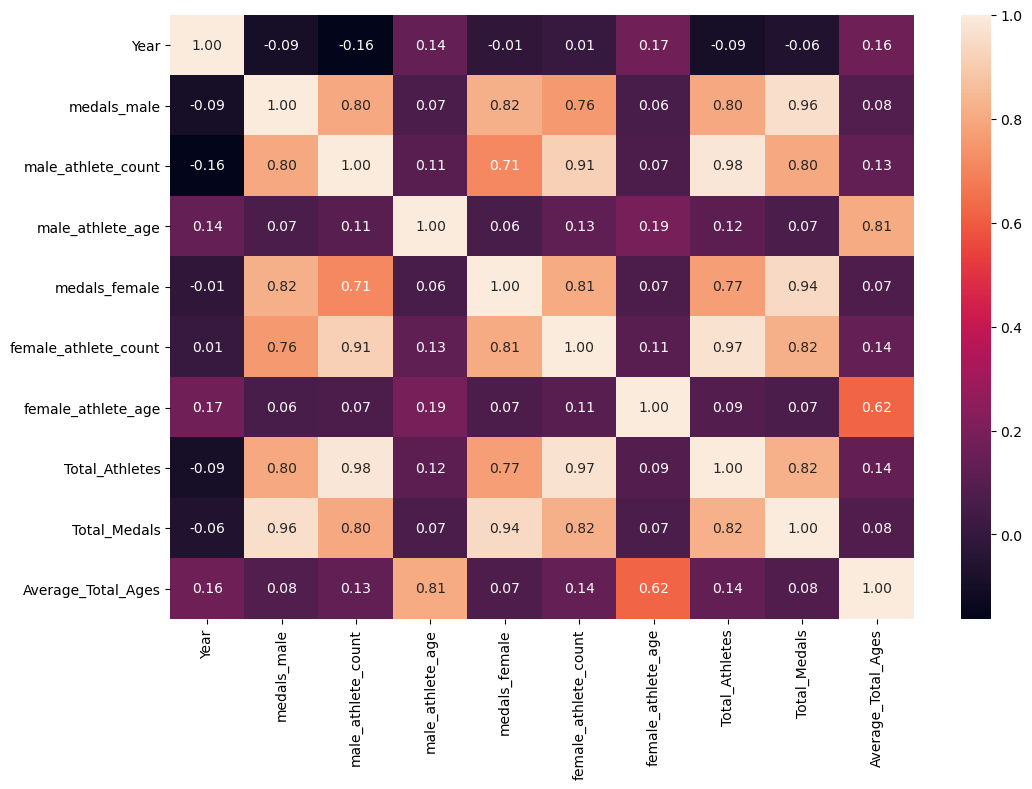

In [5]:
#check for correlations in the dataset
import seaborn as sns

#merged_df.corr()
sns.heatmap(merged_df.corr(), annot = True, fmt='.2f')

#observations:
#Since the 80s, everything has decreased overtime except average athlete age for both genders, they are getting older
#Total medals correlates strongest with male medals



The scatterplot visualizes the correlation score clearly, with a best fit line revealing that more athletes leads to more medals with a convincing R squarred value of 0.68. Setting the color scale to the year of the Olympics indicates that the relationship has been fairly stable over time.

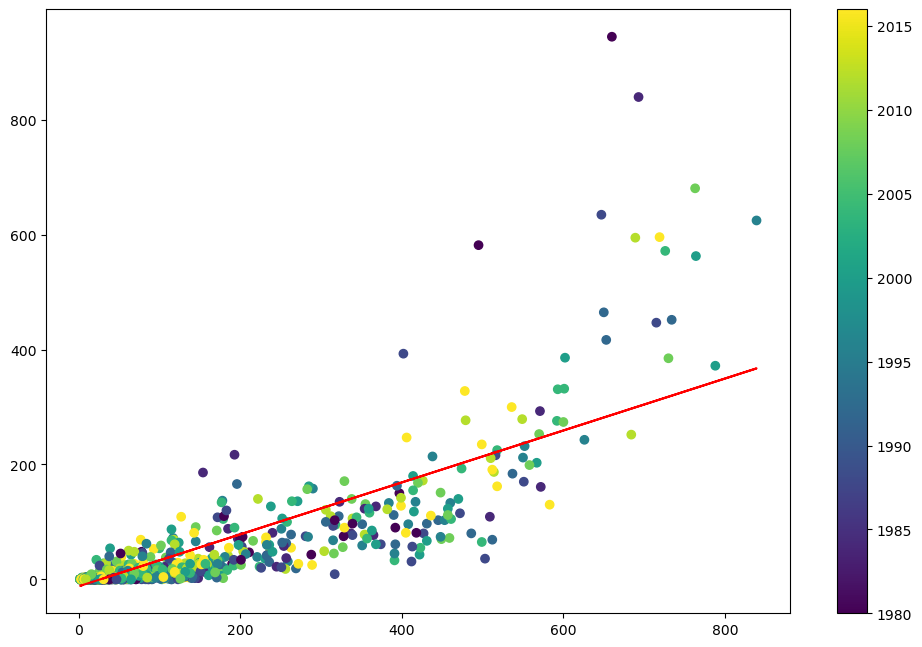

0.6795049111265645

In [6]:
#Is there a correlation between number of athletes and number of medals? Yes, overall the more athletes the more medals.
import sklearn 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

#linear regression
X = merged_df.loc[:, 'Total_Athletes'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = merged_df.loc[:, 'Total_Medals'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Year = merged_df.loc[:, 'Year'].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X, Y, c=Year)
plt.plot(X, Y_pred, color='red')
plt.colorbar()
plt.show()

#find the coefficients
r2_test = r2_score(Y, Y_pred) # Rsquared here
r2_test

Another interesting observation from correlelogram was the fact that there is a positive correlation with the year of the games and the average age of the athletes of both genders, 0.13 for male athletes and 0.18 for female athletes. This correlation suggests two things, that the average age of the athletes has slowly increased over time and that females are increasing faster than males. The line plot below visualizes these trends, as well as the impressive increase in the percentage of female athletes. 

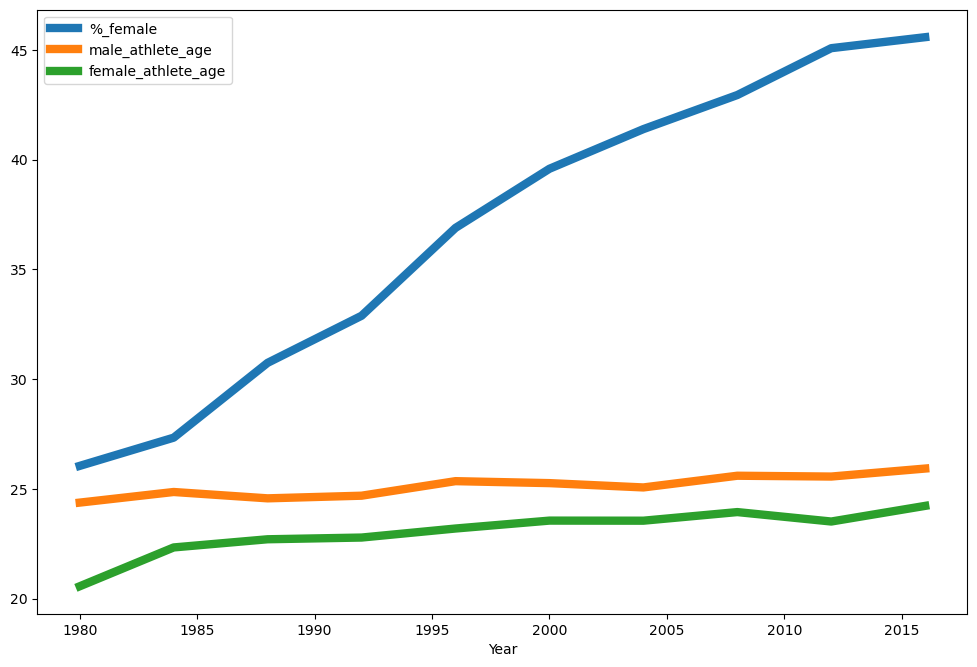

Average Male Age:  25.127495993261107
Average Feale Age:  23.038620286582294
   Year  Total_Athletes  male_athlete_count  female_athlete_count  \
0  1980            6741                4985                  1756   
1  1984            8952                6505                  2447   
2  1988           11515                7975                  3540   
3  1992           12540                8416                  4124   
4  1996           13568                8563                  5005   
5  2000           13721                8290                  5431   
6  2004           13393                7850                  5543   
7  2008           13542                7727                  5815   
8  2012           12892                7081                  5811   
9  2016           13650                7429                  6221   

   male_athlete_age  female_athlete_age  Average_Total_Ages   %_female  
0         24.376786           20.566071           23.475000  26.049548  
1         24.8600

In [18]:
#aggregate further to by year instead of country / year

Sum_by_year = merged_df.groupby(['Year']).agg({  'Total_Athletes':'sum',
                                               'male_athlete_count':'sum',
                                               'female_athlete_count':'sum',
                                                 'male_athlete_age':'mean',
                                                 'female_athlete_age':'mean',
                                                 'Average_Total_Ages':'mean'}).reset_index()

Sum_by_year['%_female'] = Sum_by_year['female_athlete_count']/(Sum_by_year['male_athlete_count']+Sum_by_year['female_athlete_count'])*100

Sum_by_year.plot(x="Year", y=["%_female", "male_athlete_age", "female_athlete_age"], linewidth=6)
plt.show()

print("Average Male Age: ", Sum_by_year['male_athlete_age'].mean())
print("Average Feale Age: ", Sum_by_year['female_athlete_age'].mean())

print(Sum_by_year)

While female athletes are making considerable gains in equal representation, the age difference is quite striking and relatively stable over the years. This begs the question, why is the average female athlete 2.12 years younger than the average male. One possible answer is that the sports which attract move female athletes tend to favor younger athletes, for example where technique can be mastered while the body mass is relatively smaller. As a first looks at this possibility, the average age per sport was measured along with the distribution of the genders into that sport. There are indeed differences in age per sport and differences in the distribution of each gender in each sport. Further more, the product of the gender distribution and the average age by sport sum up to approximately the observed age differences (23.8 vs.23.3 for females and 25.0 vs. 25.3 for males).

Expected Female Age by Sport:  23.840250742890884
Actual Female Age by Sport:  23.33249027237357
Expected Male Age by Sport:  25.00114523969183
Actual Male Age by Sport:  25.256939040207488
                Sport  Dist_fem  Dist_masc  Average_Age  fem_Age_product  \
0           Athletics  0.189875   0.161106    25.743570         4.888062   
1            Swimming  0.147345   0.107974    21.150786         3.116466   
2          Gymnastics  0.100112   0.078869    20.776611         2.079979   
3              Rowing  0.043383   0.047394    25.863427         1.122037   
4            Shooting  0.037367   0.047510    31.355273         1.171647   
5              Hockey  0.031919   0.023678    25.588683         0.816773   
6             Cycling  0.030497   0.055023    25.885255         0.789430   
7            Handball  0.028856   0.022732    26.591059         0.767324   
8             Fencing  0.028397   0.032304    26.267919         0.745931   
9          Volleyball  0.026275   0.017758    25.4

<AxesSubplot:ylabel='Sport'>

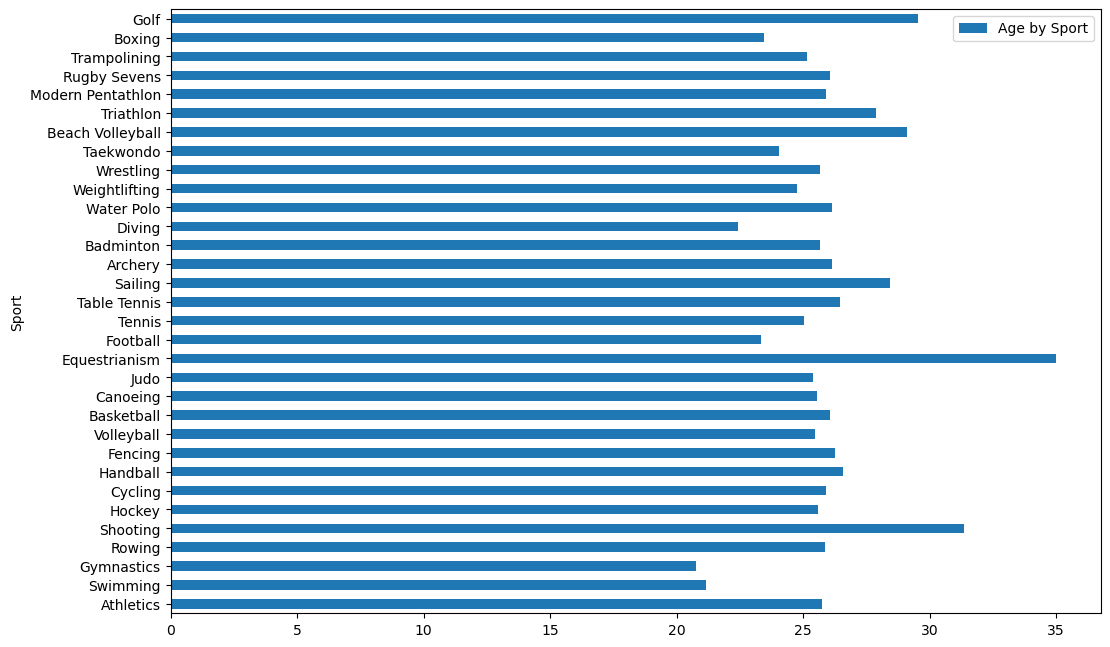

In [17]:
#Break down age by sport and then distribution of females by sport to see if that accounts for the age difference
Athletes_df['Sport']

#select the columns and parameters I want
Sports_df = Athletes_df[['ID','Sex','Age','NOC','Year','Sport','Season']]

Sports_df = Sports_df[Sports_df['Year'] >= 1980]

Sports_df = Sports_df[Sports_df['Season'] == 'Summer']

#check the number of sports
status_vals = Sports_df.Sport.value_counts()
#print(status_vals)

Age_by_sport = Sports_df.groupby(['Sport']).agg({'Age':'mean'}).reset_index()
Age_by_sport

#Age_by_sport['Age'].hist(bins = 20)

#Now find the distribution of athletes by gender into the different sports

#subset the Sports dataframe into male and female
Sport_f = Sports_df[Sports_df['Sex'] == 'F']
Sport_m = Sports_df[Sports_df['Sex'] == 'M']
        
#Now find distribution of each sex by sport
Sport_Dist_Fem = (Sport_f['Sport'].value_counts() / Sport_f.shape[0]).to_frame()
Sport_Dist_Masc = (Sport_m['Sport'].value_counts() / Sport_m.shape[0]).to_frame()

#convert the rownames to a column
Sport_Dist_Fem.index.name = 'Sport_Name'
Sport_Dist_Fem.reset_index(inplace=True)
Sport_Dist_Fem.columns = ['Sport', 'Distribution']

Sport_Dist_Masc.index.name = 'Sport_Name'
Sport_Dist_Masc.reset_index(inplace=True)
Sport_Dist_Masc.columns = ['Sport', 'Distribution']

#Merge into one table to compare, rename and round values 
merged_Sport_Dist_Gend = pd.merge(Sport_Dist_Fem, Sport_Dist_Masc, on=['Sport'])
merged_Sport_Dist_Gend = pd.merge(merged_Sport_Dist_Gend, Age_by_sport, on=['Sport'])
merged_Sport_Dist_Gend.columns = ['Sport', 'Dist_fem', 'Dist_masc', 'Average_Age']
merged_Sport_Dist_Gend

#add weighted averages column and sum up as expected age distribution, then compare that to actuals
merged_Sport_Dist_Gend['fem_Age_product'] = merged_Sport_Dist_Gend['Dist_fem']*merged_Sport_Dist_Gend['Average_Age']
merged_Sport_Dist_Gend['Male_Age_product'] = merged_Sport_Dist_Gend['Dist_masc']*merged_Sport_Dist_Gend['Average_Age']

#view results
print("Expected Female Age by Sport: ", merged_Sport_Dist_Gend['fem_Age_product'].sum())
print("Actual Female Age by Sport: ", merged_df['female_athlete_age'].mean())
print("Expected Male Age by Sport: ", merged_Sport_Dist_Gend['Male_Age_product'].sum())
print("Actual Male Age by Sport: ", merged_df['male_athlete_age'].mean())

#print(merged_Sport_Dist_Gend)

# Show a visual comparison
plotdata = pd.DataFrame({
    "Age by Sport":merged_Sport_Dist_Gend['Average_Age'].to_list()
    #"% of male athletes":merged_Sport_Dist_Gend['Dist_fem'].to_list(),
    #"% of female athletes":merged_Sport_Dist_Gend['Dist_masc'].to_list()
    }, 
    index=merged_Sport_Dist_Gend['Sport']
)

# Plot a bar chart
plotdata.plot(kind="barh")


However, since we are dealing with averages, we need to rule out the possibility that the difference in sport age is a reflection of the gender distribution itself. A look at the average age by sport indicates that with only a few exceptions in cycling, boxing, and football, female athletes are on average younger than their male counterparts.

                Sport   Age_Male  Age_Female  Fem_%_of_Male  Male_:_Female
0             Archery  26.617149   25.594267      -0.038429       1.105843
1           Athletics  25.762082   25.717221      -0.001741       1.433114
2           Badminton  26.315202   25.047297      -0.048181       0.968919
3          Basketball  26.362299   25.659628      -0.026654       1.206081
4    Beach Volleyball  29.895833   28.315217      -0.052871       1.043478
5              Boxing  23.372208   26.638889       0.139768      43.222222
6            Canoeing  25.548418   25.573684       0.000989       2.753509
7             Cycling  25.548679   26.899570       0.052875       3.047346
8              Diving  22.975765   21.854422      -0.048805       1.072109
9       Equestrianism  35.182199   34.631376      -0.015656       2.065448
10            Fencing  26.455900   25.908320      -0.020698       1.921418
11           Football  22.709690   24.909091       0.096849       2.613636
12               Golf  32

<AxesSubplot:xlabel='Sport'>

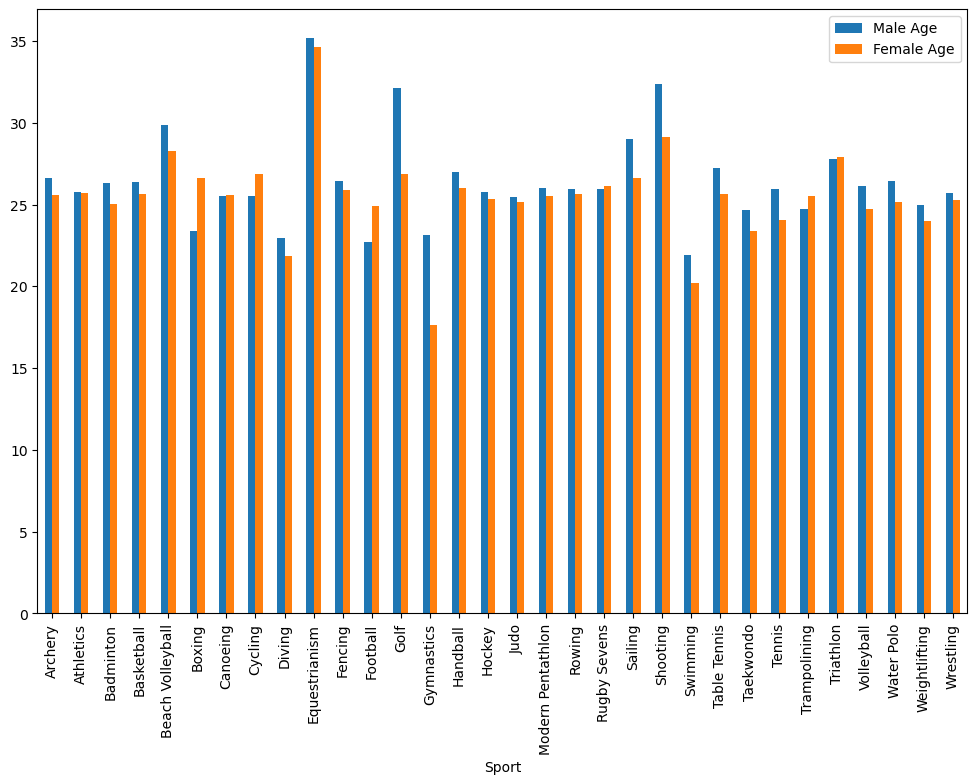

In [10]:
#finally check if the average age by sex within each sport is significantly different.
#Age_by_sport = Sports_df.groupby(['Sport']).agg({'Age':'mean'}).reset_index()
#Age_by_sport

#select the columns and parameters I want
Ath_df_sport = Athletes_df[['ID','Sex','Age','NOC','Year','Season','Medal','Sport']]
Ath_df_sport = Ath_df_sport[Ath_df_sport['Year'] >= 1980]
Ath_df_sport = Ath_df_sport[Ath_df_sport['Season'] == 'Summer']

#subset into male and female datasets
Ath_df_m = Ath_df_sport[Ath_df_sport['Sex'] == 'M']
Ath_df_f = Ath_df_sport[Ath_df_sport['Sex'] == 'F']

#Age_by_Sport_Act = Sports_df.groupby(['Sport'],['Sex']).agg('Age':'mean').reset_index()

#now add up the medal numbers by country using this formula:  df['Data4'] = df['Data3'].groupby(df['Date']).transform('sum
#Age_by_Sport_Act = Ath_df_m.groupby(['Sport','Sex']).agg({'Age':'mean'}).reset_index()

#Age_by_Sport_Act

Ath_df_m = Ath_df_m.groupby(['Sex','Sport']).agg({'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

Ath_df_f = Ath_df_f.groupby(['Sex','Sport']).agg({'ID':'count',
                                                 'Age':'mean'
                                                }).reset_index()

merged_age_by_sport = pd.merge(Ath_df_m, Ath_df_f, on=['Sport'])
merged_age_by_sport.columns = ['Sex', 'Sport', 'Count_Male', 'Age_Male','Sex','Count_Female','Age_Female']

#add column representing female as % of male
merged_age_by_sport['Fem_%_of_Male'] = (merged_age_by_sport['Age_Female']-merged_age_by_sport['Age_Male'])/merged_age_by_sport['Age_Male']
merged_age_by_sport['Male_:_Female'] = (merged_age_by_sport['Count_Male']/merged_age_by_sport['Count_Female'])


#remove unnecessary columns
merged_age_by_sport = merged_age_by_sport[['Sport','Age_Male','Age_Female','Fem_%_of_Male','Male_:_Female']]
print(merged_age_by_sport)


# Show a visual comparison
plotdata = pd.DataFrame({
    "Male Age":merged_age_by_sport['Age_Male'].to_list(),
    "Female Age":merged_age_by_sport['Age_Female'].to_list()
    }, 
    index=merged_age_by_sport['Sport']
)

# Plot a bar chart
plotdata.plot(kind="bar")
